# Image segmentation (with U-Nets)


In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from os import listdir
import skimage
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.misc as m
from torch.optim.lr_scheduler import StepLR
import cv2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
torch.cuda.is_available()

True

## U-Net Architecture
![architecture](.\architecture.png "UNet architecture")

### Contracting Path
It consits of 4 blocks and every block has the same architecture (typical architecture of a concolutional network)
1. Two 3x3 unpadded convolutions each followed by a rectified linear unit
    - because its is unpadded we loss with every convolution 2 pixels in each dimension
2. 2x2 max pooling operations with stride 2
    - with this setting the image get downsampled by a factor of 2

They start with 64 feature channels (filters) at the first block and with each block they double the number of feature channels

The output of the last block will be sended through two convoltuion layers (3x3) each followed by a ReLU, because of the doubling of the feature channels the resulting feature map for each layer is 1024 dimensional.

### Expansive Path
Its symetric to the contracting path, so again 4 blocks. However the architecture changes slightly
1. Upsampling by a 2x2 up-convolution (that halves the number of feature channels)
2. Copy a cropped version of the feature map from the corresponding feature map of the contracting path and concatenate with the upsampled feature map
    - The cropping is necessary due to the loss of border pixels in every convolution
3. Two 3x3 unpadded convolutions each followed by a rectified linear unit

At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes (in our case 2 classes). 

In total the network has 23 convolutional layers. (2\*4 (Contracting Path) + 2 (last layer) + 3\*4 (Expansive Path) + 1 (final layer))

In [0]:
# because 18 of the 23 convolutional layers uses the same setting, we defined a own function for this
def conv3x3(_input, output):
    return nn.Conv2d(_input, output, 3, padding=1)

def conv_upsample(in_channels,channels,i):
    # a = (i+2p-k)mod s
    s = 2
    k = 2
    p = 0
    a = np.mod(i+2*p-k,s)
    return nn.ConvTranspose2d(in_channels=in_channels, out_channels=channels, kernel_size=k, stride=s, output_padding=a)


# define block of contracting path
class ContractingBlock(nn.Module):
    def __init__(self,in_channels,channels):
        super(ContractingBlock, self).__init__()
        # for the first conv layer the number of input channels are the number of channels from the previous block and they will be doubled (first block starts with 64) 
        self.conv1 = conv3x3(in_channels,channels)
        self.conv2 = conv3x3(channels,channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample_block = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x, isInitBlock = 0):
        if not isInitBlock:
            x = self.downsample_block(x)
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        #print(x.size())
        
        return x

# define block of expansive path
class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, channels,target_size):
        super(ExpansiveBlock, self).__init__()
        self.upsampled = conv_upsample(in_channels, channels,target_size)
        self.conv1 = conv3x3(in_channels,channels)
        self.conv2 = conv3x3(channels,channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, cop):
        x = self.upsampled(x)
        #n, c, h, w = x.size()
        #cop = cop[0:n,0:c,0:h,0:w]
        x = torch.cat([cop, x], dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        #print(x.size())
        
        return x


In [0]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.contracted1 = ContractingBlock(3,64)
        self.contracted2 = ContractingBlock(64,128)
        self.contracted3 = ContractingBlock(128,256)
        self.contracted4 = ContractingBlock(256,512)
        self.bottom = ContractingBlock(512,1024)
        self.expanded1 = ExpansiveBlock(1024,512,36)
        self.expanded2 = ExpansiveBlock(512,256,73)
        self.expanded3 = ExpansiveBlock(256,128,146)
        self.expanded4 = ExpansiveBlock(128,64,292)
        self.final = nn.Conv2d(64, 2, 1, padding=0)
        
    def forward(self,x):
        con1 = self.contracted1(x, 1)
        con2 = self.contracted2(con1)
        con3 = self.contracted3(con2)
        con4 = self.contracted4(con3)
        bot = self.bottom(con4)
        exp1 = self.expanded1(bot,con4)
        exp2 = self.expanded2(exp1,con3)
        exp3 = self.expanded3(exp2,con2)
        exp4 = self.expanded4(exp3,con1)
        fin = self.final(exp4)
        
        return fin



## Weight Initialization

In [0]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        o,i,h,w = m.weight.size()
        N = i*h*w
        std = np.sqrt(2/N)
        #print(m.weight.data[1][1])
        m.weight.data.normal_(0.0, std)
        #print(m.weight.data[1][1])
        #print(N)
        #print(std)     

## Loss-Function
For the loss a pixel-wise soft-max over the final feature map combined with the corss entropy loss function is computed.
The function torch.nn.functional.corss_entropy() does exactly this.

In [0]:
def EngergyFunction(featuremap, target):
    featuremap = featuremap.transpose(1, 2).transpose(2, 3).contiguous().view(-1, 2)
    #target = target/255
    #target = target+1
    target = target.contiguous().view(-1)
    loss = F.cross_entropy(featuremap, target,weight = torch.tensor([1., 3.]).to(device),  reduction='elementwise_mean') #, weight = torch.tensor([1., 2.75]))
    # weight = 2.75 -> just black, weight = 3.5 -> mask
    return loss
        

## Dataloader

In [0]:
def dataLister(image_path,label_path):
    data = listdir(image_path)
    labels = listdir(label_path) 
    # sorting is unnecessary on windows, but colab is a bit stupid
    data.sort()
    labels.sort()
    combined = list()
    for d, l in zip(data, labels):
        combined.append((image_path + d, label_path + l))
   
    return combined

In [0]:
class SegmentationDataset(data.Dataset):
    def __init__(self, datalist):
        self.datalist = datalist
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        
    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, index):
        image = Image.open(self.datalist[index][0])
        image = np.array(image, dtype=np.uint8)
        label = Image.open(self.datalist[index][1])
        label = np.array(label, dtype=np.uint8)
        image,label = self.transform(image,label)
        # padding for quadratic input
        image = F.pad(image, (10,0), 'constant', 0)
        label = F.pad(label, (10,0), 'constant', 0)
        #print(image.size())
        return image,label
    
    def transform(self, image, label):
        image = m.imresize(image, (292,282),'nearest')
        label = m.imresize(label, (292,282),'nearest')
        # make sure that there are only 0 and 1 in the label
        mask = np.full((292, 282), 1)
        label = np.logical_and(label, mask)
        label = label.astype(int)
        #print(image.shape)
        image = image[:, :, ::-1]  # RGB -> BGR????
        image = image.astype(np.float64)
        image -= self.mean
        image = image.astype(float) / 255.0
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()
        return image,label

train_image_path = '/content/drive/My Drive/UNet/data/training/images/'
train_label_path = '/content/drive/My Drive/UNet/data/training/label/'
test_image_path = '/content/drive/My Drive/UNet/data/test/images/'
test_label_path = '/content/drive/My Drive/UNet/data/test/1st_manual/'
trainlist = dataLister(train_image_path,train_label_path)
train_dataset = SegmentationDataset(trainlist)
train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True)
testlist = dataLister(test_image_path,test_label_path)
test_dataset = SegmentationDataset(testlist)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [0]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.reshape(npimg, (292, 292))
    plt.imshow(npimg)
    plt.show()

## Optimizer
Like described in [1] we use stochastic gradient descent with a momentum of 0.99 for optimization.

In [0]:
unet = UNet().to(device)
unet.apply(weights_init)
optimizer = optim.Adam(
        unet.parameters(), 
        lr=0.001,weight_decay=0.0005)

In [0]:
scheduler = StepLR(
        optimizer, 
        step_size=30, 
        gamma=0.1)

## Train Network

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:16: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 9.775688529014587


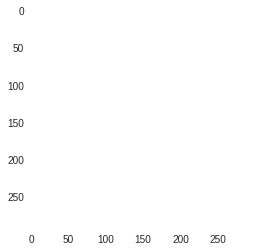

1 8.392608642578125


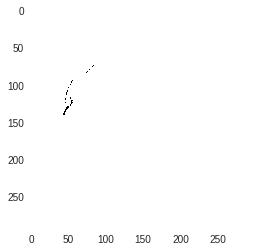

2 8.144109398126602


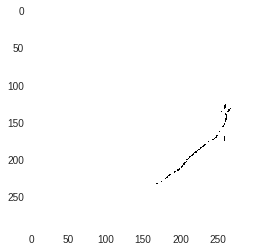

3 7.699079602956772


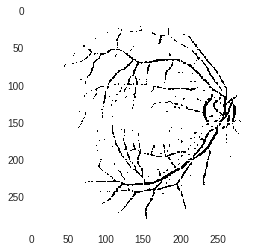

4 6.950974643230438


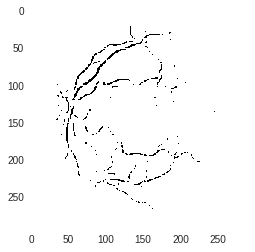

5 5.849860042333603


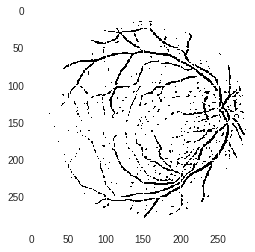

6 5.286900371313095


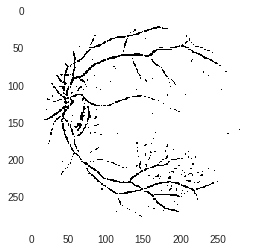

7 4.8638018518686295


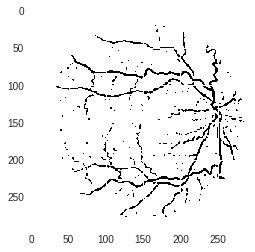

8 4.622290745377541


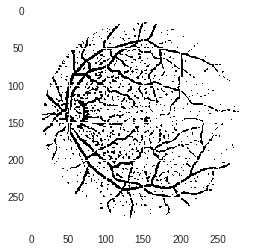

9 4.591471046209335


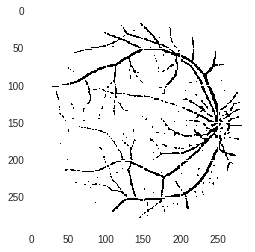

10 4.679980024695396


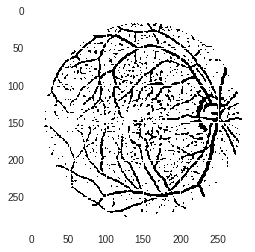

11 5.285700559616089


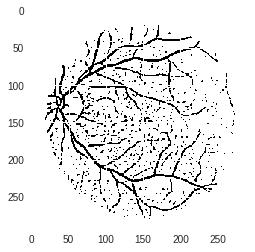

12 4.523244932293892


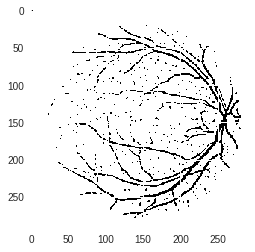

13 4.335324555635452


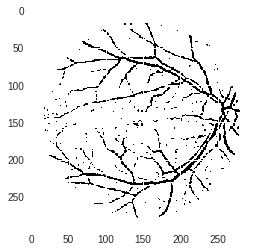

14 4.270777210593224


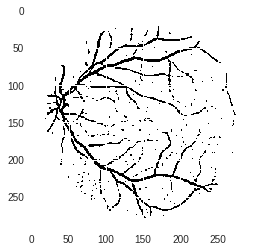

15 4.162338823080063


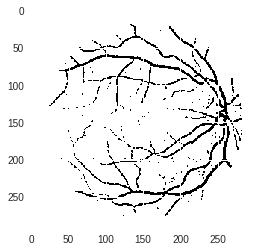

16 4.104548320174217


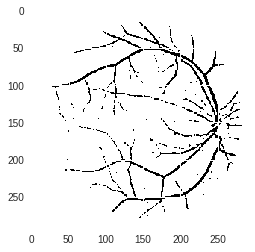

17 4.526206463575363


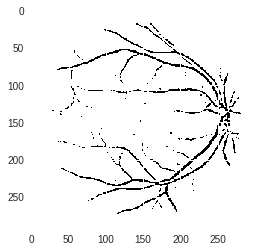

18 4.232896000146866


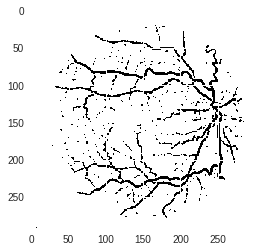

19 4.079303368926048


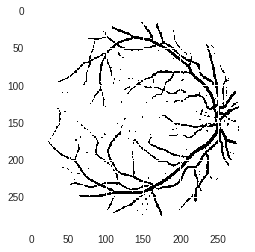

20 4.093311220407486


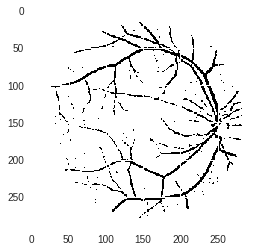

21 3.957965984940529


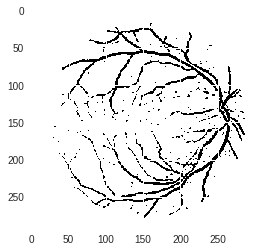

22 3.944372445344925


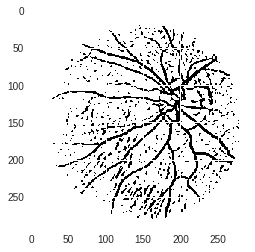

23 4.121914863586426


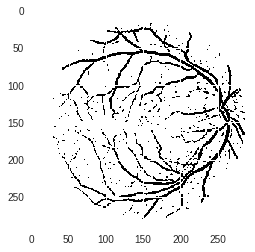

24 3.9259091168642044


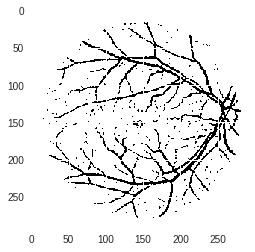

25 3.9294061958789825


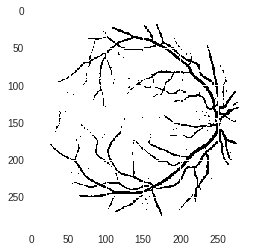

26 3.8364561796188354


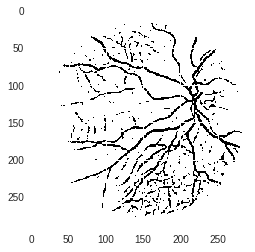

27 3.9464268535375595


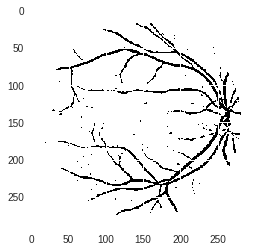

28 3.761372908949852


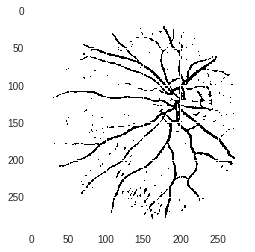

29 3.7927467226982117


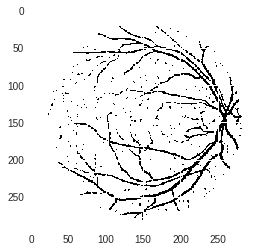

30 3.9241571575403214


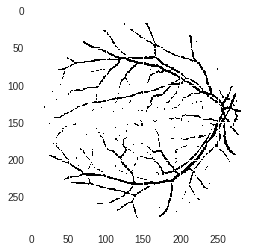

31 3.8206303864717484


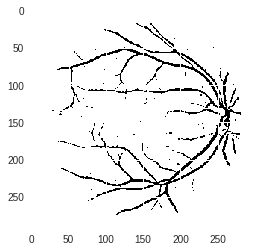

32 3.786750614643097


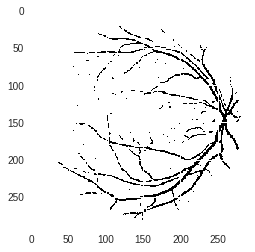

33 3.722339168190956


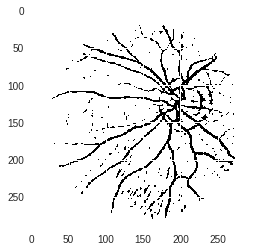

34 3.941584661602974


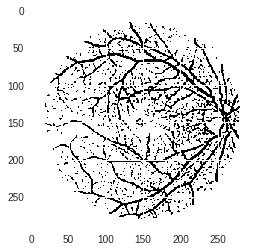

35 3.6244166791439056


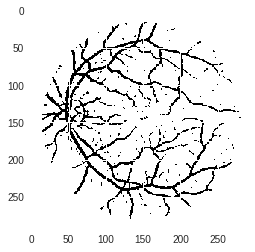

36 3.515933856368065


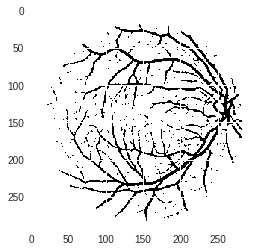

37 3.5272859781980515


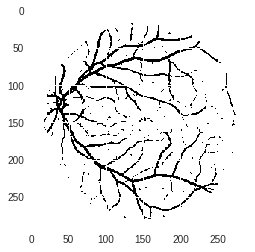

38 3.48740716278553


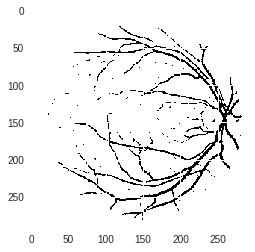

39 3.538939893245697


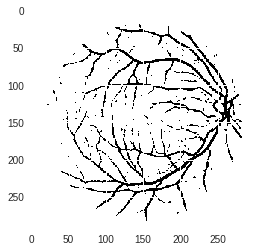

40 3.425189271569252


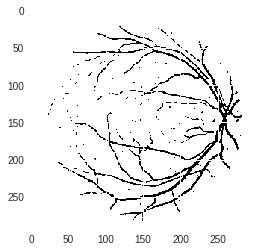

41 3.4188544005155563


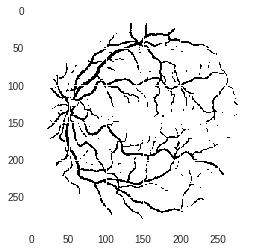

42 3.5085012167692184


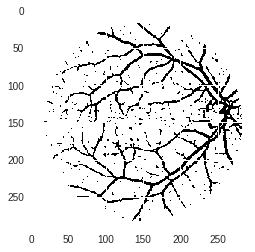

43 3.3725800812244415


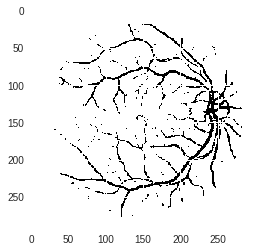

44 3.4515735059976578


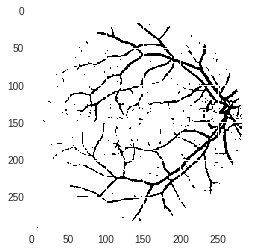

45 3.5359217822551727


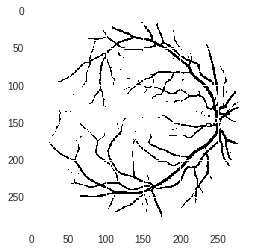

46 3.457485020160675


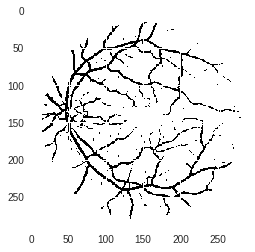

47 3.560068964958191


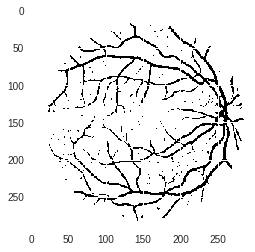

48 3.3889288157224655


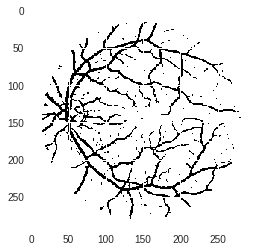

49 3.370271146297455


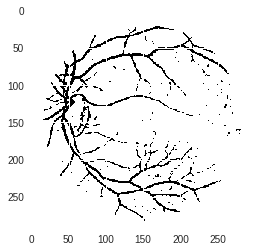

50 3.3563754484057426


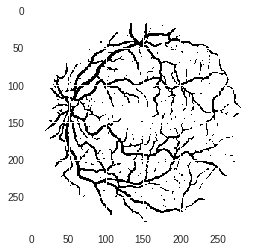

51 3.3045334443449974


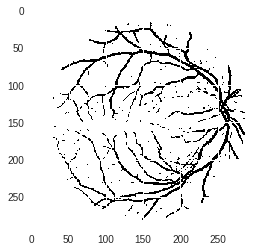

52 3.2943332344293594


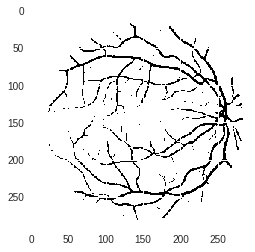

53 3.6478446424007416


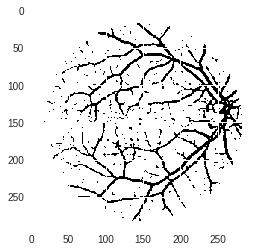

54 3.355011835694313


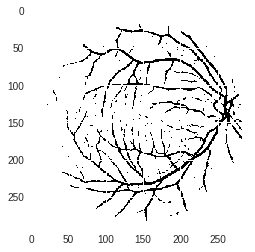

55 3.34945747256279


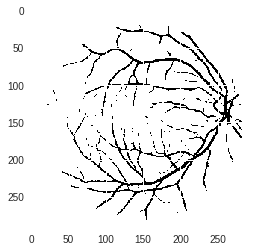

56 3.412566863000393


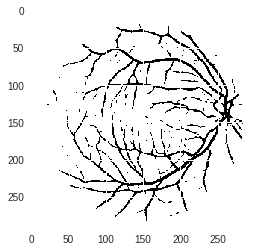

57 3.278644748032093


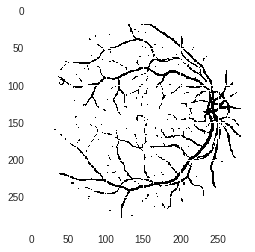

58 3.2399819046258926


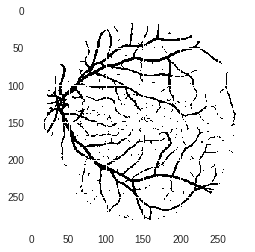

59 3.258025959134102


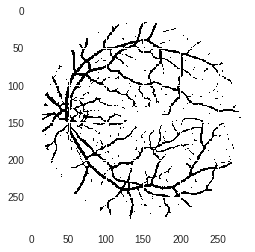

60 3.1581564620137215


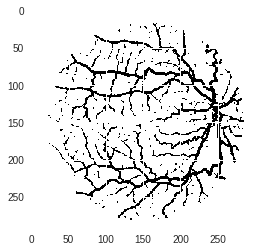

61 3.2118414267897606


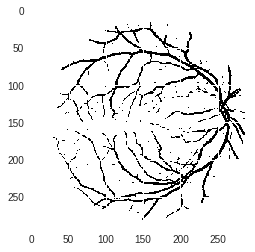

62 3.2567861825227737


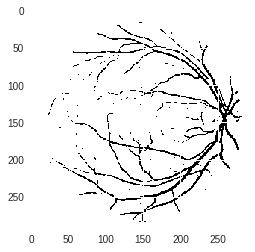

63 3.2506087124347687


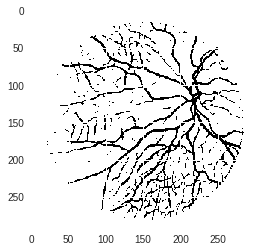

64 3.3281825482845306


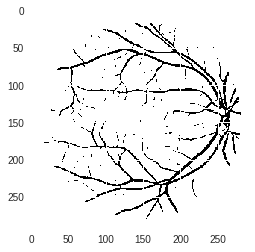

65 3.247050330042839


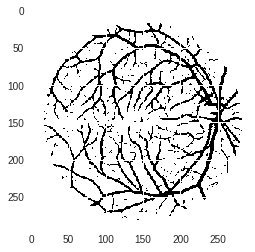

66 3.267049863934517


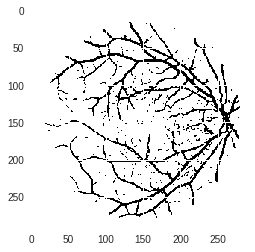

67 3.4812725633382797


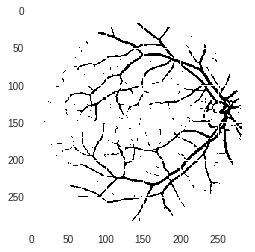

68 3.3119583129882812


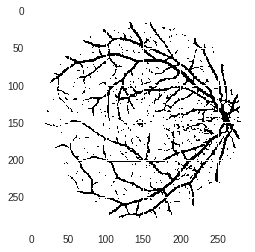

69 3.2503851801156998


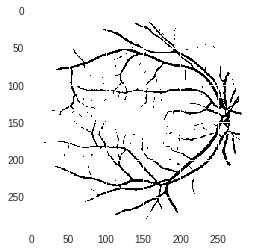

70 3.1678845807909966


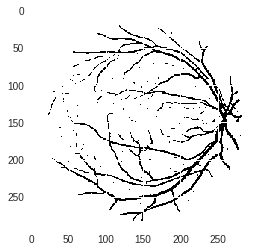

71 3.1964870616793633


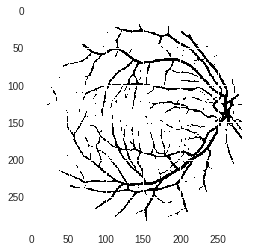

72 3.328329972922802


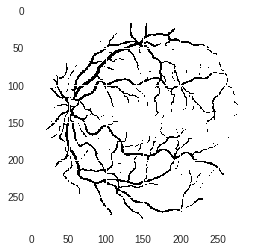

73 3.2418584525585175


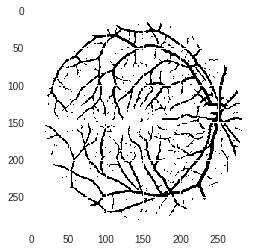

74 3.191463626921177


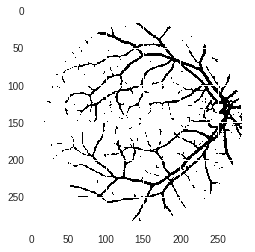

75 3.2206011191010475


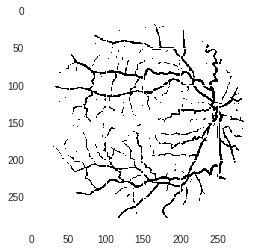

76 3.3376257941126823


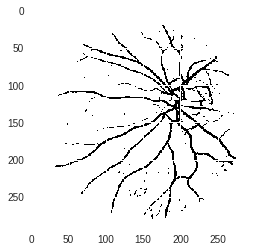

77 3.5110431760549545


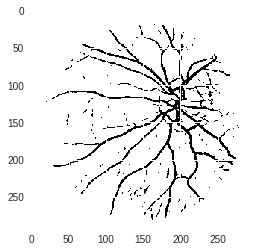

78 3.4803490340709686


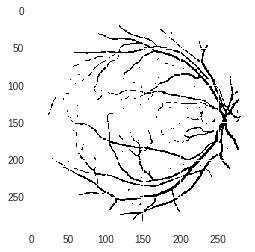

79 3.2428366020321846


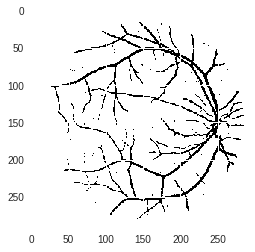

80 3.2402433156967163


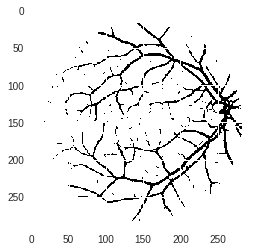

81 3.1507217809557915


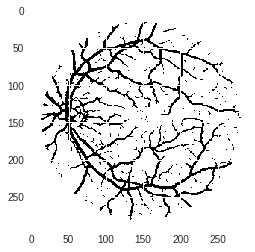

82 3.095314174890518


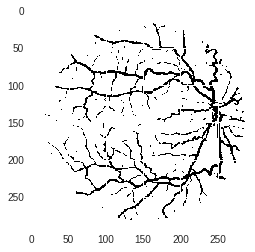

83 3.0723622143268585


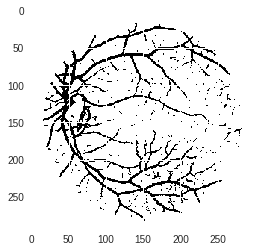

84 3.13144401460886


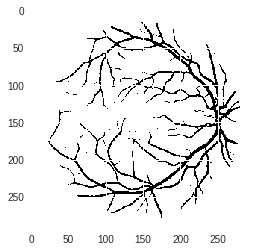

85 3.1017670407891273


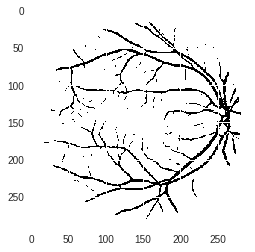

86 3.090806506574154


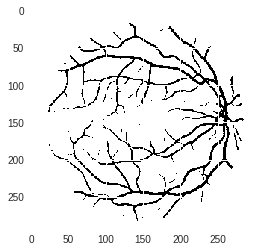

87 3.2163801342248917


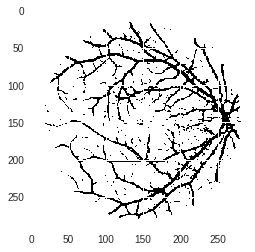

88 3.1456203907728195


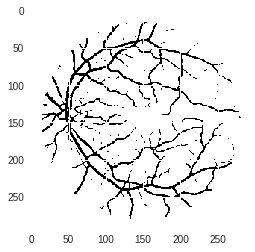

89 3.2037606984376907


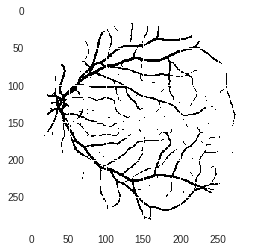

90 3.073516897857189


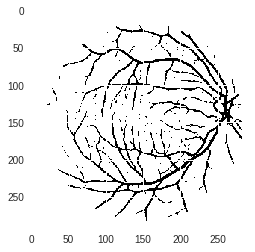

91 3.0759106799960136


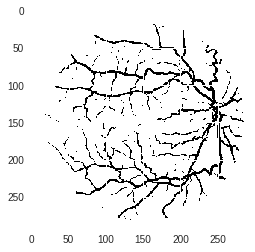

92 3.0742432326078415


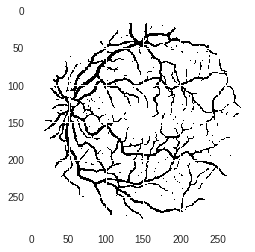

93 3.1685710847377777


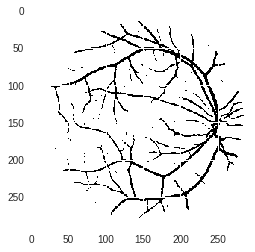

94 3.0877547785639763


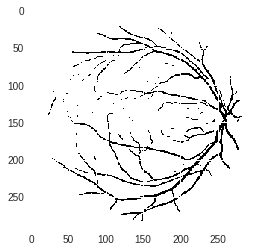

95 3.0613375678658485


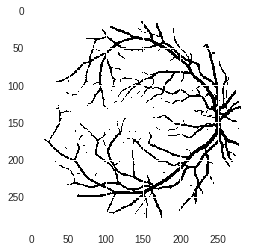

96 3.0454135686159134


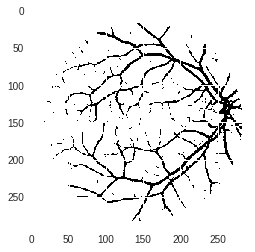

97 3.0877380445599556


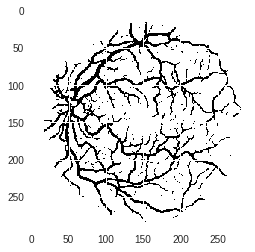

98 3.148582510650158


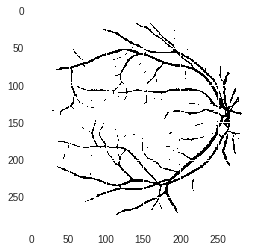

99 3.1301445439457893


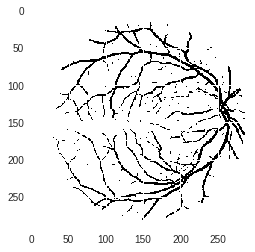

In [0]:
losses = []
unet.train()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loss seems to converge after 1o epochs to 1.53
for epoch in range(100):
    epoch_loss = 0
    #scheduler.step()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        #print(inputs.size())
        #print(labels.size())
        #imshow(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = unet(inputs)
        loss = EngergyFunction(output,labels)
        epoch_loss += loss.item() # logging
        
        loss.backward()
        optimizer.step()

    losses.append(epoch_loss)
    print(epoch,epoch_loss)
    pred = output.data.max(1)[1].cpu().numpy()
    pred = np.resize(pred,(292,292))
    plt.imshow(pred)
    plt.show()

## Parameter Tuning
The average accuracy of a complete black image is 0.816459467066992.

| Optimizer | Loss | OtherSettings | Epochs | Accuracy | Loss after last Epoch | Comments
|:--- | :--- | --- | --- | --- |
| Adam: lr = 0.0001, weight_decay=0.0005 | weight \[1, 3\] | x | 40 | 0.89 | 5.5 | most parts of the veins clear visible with speckles around
| Adam: lr = 0.001, weight_decay=0.0005 | weight \[1, 3\] | x | 40 | 0.91 | 5.9 | most parts of the veins clear visible with speckles around
| SGD: lr = 0.001,weight_decay=0.0005,momentum=0.99 | weight \[1, 3\] | x | 40 | 0.816 | 8.95 | part of veins visible with lot of speckles around
| SGD: lr = 0.001,weight_decay=0.0005,momentum=0.99 | weight \[1, 3\] | StepLr: step_size=30, gamma=0.1  | 40 | 0.812 | 8.71 | part of veins visible with lot of speckles around
| SGD: lr=0.01,weight_decay=0.0005,momentum=0.99 | weight \[1, 3\] | x | 40 | 0.89 | 8.05 | part of veins visible with lot of speckles around


## Plot Epoch-Loss

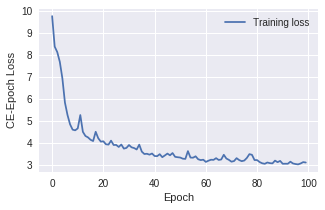

In [0]:
plt.figure(figsize=(5,3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('CE-Epoch Loss')
plt.legend(['Training loss'])

## Evaluation of the Network

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


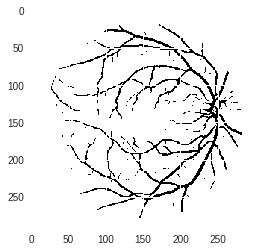

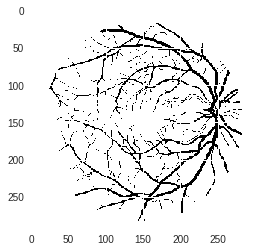

Accuracy = 0.9622818540063802
Dice coefficient = 0.78349266190925


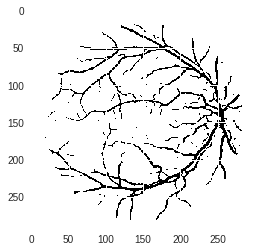

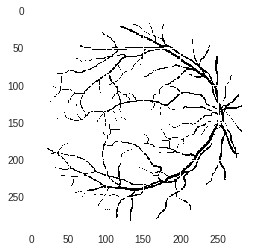

Accuracy = 0.9665274910865078
Dice coefficient = 0.7837223401030615


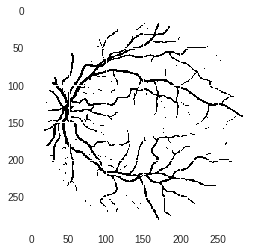

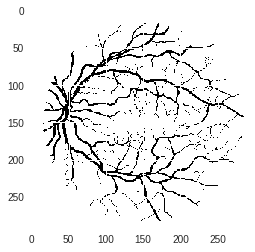

Accuracy = 0.9669027960217677
Dice coefficient = 0.8067123287671233


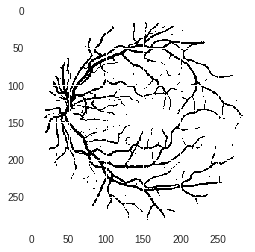

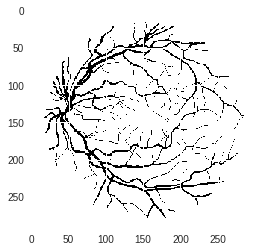

Accuracy = 0.9604170576093075
Dice coefficient = 0.7920133111480865


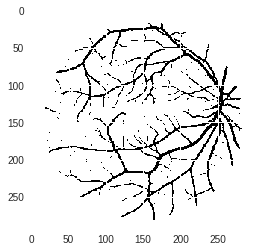

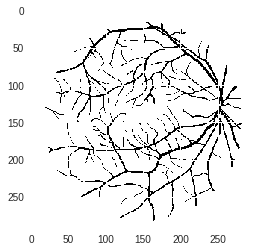

Accuracy = 0.9640059110527304
Dice coefficient = 0.8014748690083446


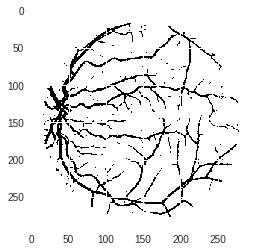

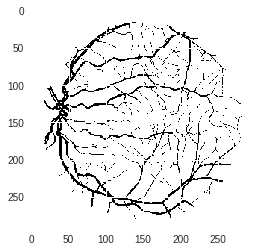

Accuracy = 0.958822011634453
Dice coefficient = 0.7732351611444811


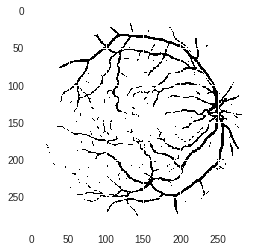

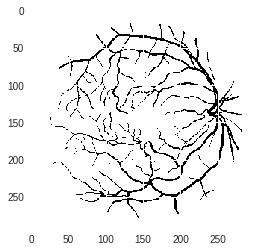

Accuracy = 0.9644281291048977
Dice coefficient = 0.7803924408080516


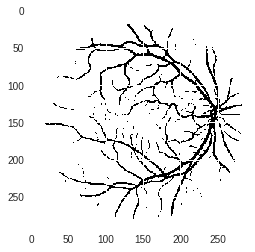

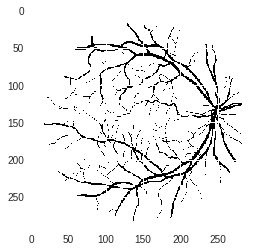

Accuracy = 0.9641818352411334
Dice coefficient = 0.7834349737625869


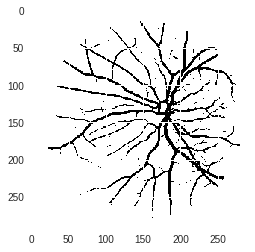

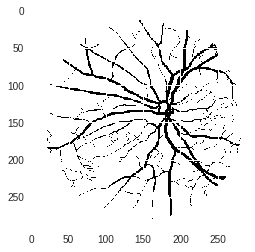

Accuracy = 0.9643460311503096
Dice coefficient = 0.8048028765891871


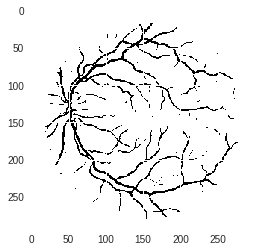

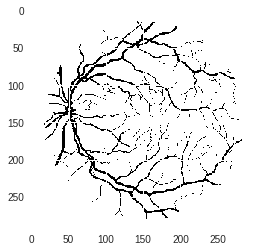

Accuracy = 0.9672663726778007
Dice coefficient = 0.7798375009860377


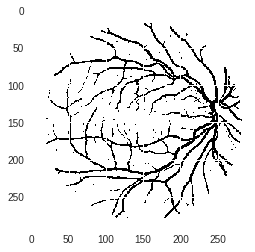

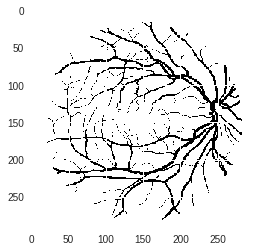

Accuracy = 0.9659645336836179
Dice coefficient = 0.8337724825294993


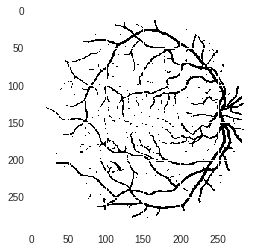

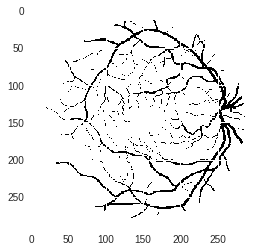

Accuracy = 0.9617071683242635
Dice coefficient = 0.7806516627477326


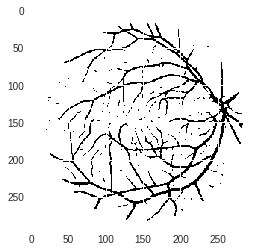

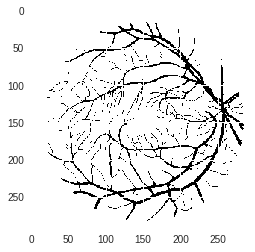

Accuracy = 0.9600417526740477
Dice coefficient = 0.7884770596635003


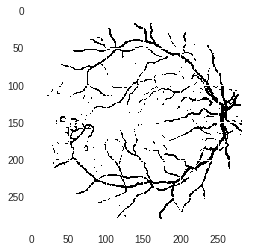

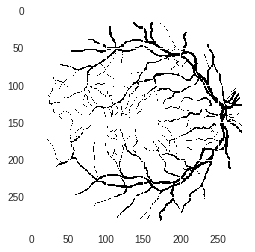

Accuracy = 0.9583059673484706
Dice coefficient = 0.742223189036328


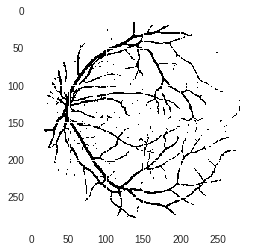

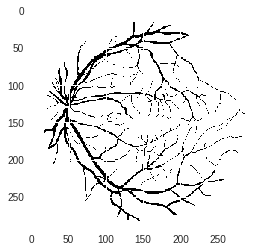

Accuracy = 0.9638417151435541
Dice coefficient = 0.7902007485539299


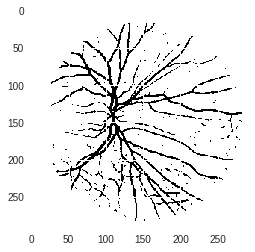

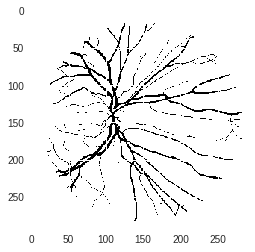

Accuracy = 0.9582355976731094
Dice coefficient = 0.7475005318017444


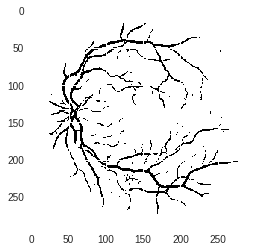

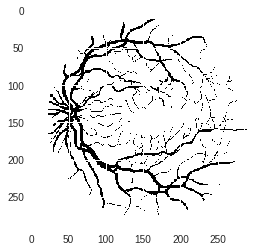

Accuracy = 0.9561127791330456
Dice coefficient = 0.7316793345762226


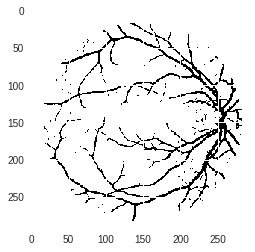

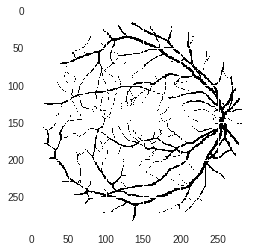

Accuracy = 0.9615547006943141
Dice coefficient = 0.782279489904357


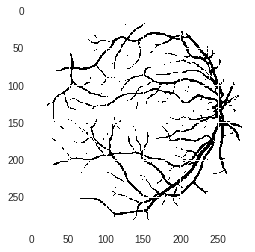

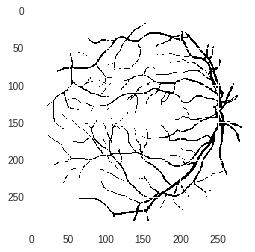

Accuracy = 0.9641466504034528
Dice coefficient = 0.7867159701388404


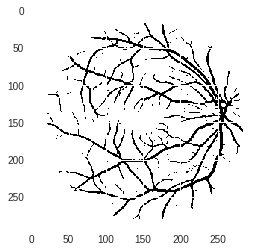

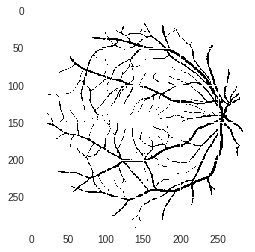

Accuracy = 0.9640293676111841
Dice coefficient = 0.8036114490619197
---------------------------------------------------
Average accuracy = 0.9626559861137173
Average dice = 0.7838115191120143


In [0]:
acc_list = []
dice_list = []
unet.eval()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, data in enumerate(test_loader, 0):
    # get the inputs
    inputs, labels = data
    inputs = inputs.to(device)
    #labels = labels.to(device)
        
    output = unet(inputs)
    pred = output.data.max(1)[1].cpu().numpy()
    pred = np.resize(pred,(292,292))
    
    pred_map = np.logical_xor(pred,labels)
    pred_map = pred_map.type(torch.DoubleTensor)
    accuracy = 1 - (torch.sum(pred_map)/(292*292))
    acc_list.append(accuracy)
    
    TP = np.multiply(pred,labels).sum()
    TP = TP.type(torch.DoubleTensor)
    dice = 2*TP/(pred.sum()+labels.sum())
    dice_list.append(dice)
    
    plt.imshow(pred)
    plt.show()

    npimg = labels.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.reshape(npimg, (292, 292))
    plt.imshow(npimg)
    plt.show()
    
    print('Accuracy =', accuracy.item())
    print('Dice coefficient =', dice.item())

print('---------------------------------------------------')
avg_acc = sum(acc_list)/len(acc_list)
print('Average accuracy =',avg_acc.item())
avg_dice = sum(dice_list)/len(dice_list)
print('Average dice =',avg_dice.item())

## References
[1] U-Net: Convolutional Networks for Biomedical Image Segmentation